In [2]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

!nvcc --version

!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'


test

In [3]:
%%cu
#include <iostream>
    int main()
{
    std::cout << "Hello from Google Colab!\n";
    return 0;
}

Hello from Google Colab!



CPU

In [11]:
%%cu
#include <stdio.h>
#include <iostream> 
#include <chrono>
#include <math.h>
#include <stdlib.h>
#include <vector>
#include <unistd.h>

float funkcja_podcalkowa(float x)
{
    return 4 * x - 6 * x + 5;
}

float metoda_prostokatow(int a, int b, int N)
{
    float s = 0.0;
    float dx = (float)(b - a) / N;

    for (int i = 1; i <= N; i++)
    {
        s += funkcja_podcalkowa(a + i * dx);
    }

    return dx * s;
}

float metoda_trapezow(int a, int b, int N)
{
    float s = 0.0;
    float dx = (float)(b - a) / N;

    for (int i = 1; i <= N; i++)
    {
        s += funkcja_podcalkowa(a + i * dx);
    }

    return dx * (s + (funkcja_podcalkowa(a) + funkcja_podcalkowa(b)) / 2);
}

float metoda_simpsona(int a, int b, int N) {
    float s  = 0;
    float st = 0;
    float dx = (b - a) / N;
    float x;
    for(int i = 1; i <= N; i++)
    {
      x = a + i * dx;
      st += funkcja_podcalkowa(x - dx / 2);
      if(i < N) s += funkcja_podcalkowa(x);
    }
    s = dx / 6 * (funkcja_podcalkowa(a) + funkcja_podcalkowa(b) + 2 * s + 4 * st);
    return s;
}

int main() {
    
    int a = 0;
    int b = 100;
    
  // zadeklaruj wektor wynikow
  std::vector<float> cpu_durations_prostokatow = { };
  std::vector<float> cpu_durations_trapezow = { };
  std::vector<float> cpu_durations_simpsona = { };

  // zadeklaruj ilosc przedzialow calkowania jako wektor
  std::vector<int> cpu_area_slices = { 100, 250, 500, 1000, 2000, 5000 };

  // PROSTOKATOW
  for (int num_of_slices : cpu_area_slices) {
    std::chrono::steady_clock::time_point start = std::chrono::steady_clock::now();
    float wynik = metoda_prostokatow(a, b, num_of_slices);
    std::chrono::steady_clock::time_point koniec = std::chrono::steady_clock::now();
    cpu_durations_prostokatow.push_back(std::chrono::duration_cast<std::chrono::microseconds>(koniec - start).count());
  }

  // TRAPEZOW
  for (int num_of_slices : cpu_area_slices) {
    std::chrono::steady_clock::time_point start = std::chrono::steady_clock::now();
    float wynik = metoda_trapezow(a, b, num_of_slices);
    std::chrono::steady_clock::time_point koniec = std::chrono::steady_clock::now();
    cpu_durations_trapezow.push_back(std::chrono::duration_cast<std::chrono::microseconds>(koniec - start).count());
  }

  // SIMPSONA
  for (int num_of_slices : cpu_area_slices) {
    std::chrono::steady_clock::time_point start = std::chrono::steady_clock::now();
    float wynik = metoda_simpsona(a, b, num_of_slices);
    std::chrono::steady_clock::time_point koniec = std::chrono::steady_clock::now();
    cpu_durations_simpsona.push_back(std::chrono::duration_cast<std::chrono::microseconds>(koniec - start).count());
  }

  for (float t : cpu_durations_prostokatow) {
      std::cout << t << ", ";
  }
  std::cout << std::endl;
  for (float t : cpu_durations_trapezow) {
      std::cout << t << ", ";
  }
  std::cout << std::endl;
  for (float t : cpu_durations_simpsona) {
      std::cout << t << ", ";
  }
  std::cout << std::endl;

    return 0;
}

1, 2, 5, 11, 22, 55, 
1, 2, 5, 11, 22, 55, 
1, 3, 7, 15, 36, 76, 



GPU

In [16]:
%%cu
#include <stdio.h>
#include <iostream> 
#include <chrono>
#include <math.h>
#include <stdlib.h>
#include <vector>
#include <unistd.h>

__device__ float funkcja_podcalkowa(float x)
{
    return 4 * x - 6 * x + 5;
}

__global__ void metoda_prostokatow(int a, int b, int N){
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx <= N) {
      float s = 0.0;
      float dx = (float)(b - a) / N;

      s += funkcja_podcalkowa(a + idx * dx);

      // return dx * s;
    }
}

__global__ void metoda_trapezow(int a, int b, int N){
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx <= N) {    
      float s = 0.0;
      float dx = (float)(b - a) / N;

      s += funkcja_podcalkowa(a + idx * dx);

      // return dx * s;
    }
}

__global__ void metoda_simpsona(int a, int b, int N){
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx <= N) {
      float s = 0.0;
      float dx = (float)(b - a) / N;

      s += funkcja_podcalkowa(a + idx * dx);

      // return dx * s;
    }
}

int main() {
    int a = 0;
    int b = 100;
    
    // zadeklaruj wektor wynikow
    std::vector<float> gpu_durations_prostokatow = { };
    std::vector<float> gpu_durations_trapezow = { };
    std::vector<float> gpu_durations_simpsona = { };

    // zadeklaruj ilosc przedzialow calkowania jako wektor
    std::vector<int> cpu_area_slices = { 100, 250, 500, 1000, 2000, 5000 };

    // PROSTOKATOW
    for (int num_of_slices : cpu_area_slices) {
      cudaEvent_t start, stop;
      cudaEventCreate(&start);
      cudaEventCreate(&stop);

      cudaEventRecord(start);
      metoda_prostokatow<<<256, 64>>>(a, b, num_of_slices);
      cudaEventRecord(stop);

      cudaEventSynchronize(stop);
      float milliseconds = 0;
      cudaEventElapsedTime(&milliseconds, start, stop);
      cudaEventDestroy(start);
      cudaEventDestroy(stop);
      gpu_durations_prostokatow.push_back(milliseconds);
    }

    // TRAPEZOW
    for (int num_of_slices : cpu_area_slices) {
        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        cudaEventRecord(start);
        metoda_trapezow<<<256, 64>>>(a, b, num_of_slices);
        cudaEventRecord(stop);

        cudaEventSynchronize(stop);
        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
        gpu_durations_trapezow.push_back(milliseconds);
    }

    // SIMPSONA
    for (int num_of_slices : cpu_area_slices) {
        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        cudaEventRecord(start);
        metoda_simpsona<<<256, 64>>>(a, b, num_of_slices);
        cudaEventRecord(stop);

        cudaEventSynchronize(stop);
        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
        gpu_durations_simpsona.push_back(milliseconds);
    }


      for (float t : gpu_durations_prostokatow) {
          std::cout << t << ", ";
      }
      std::cout << std::endl;
      for (float t : gpu_durations_trapezow) {
          std::cout << t << ", ";
      }
      std::cout << std::endl;
      for (float t : gpu_durations_simpsona) {
          std::cout << t << ", ";
      }
      std::cout << std::endl;
}


0.13088, 0.010208, 0.010208, 0.010208, 0.013472, 0.010176, 
0.010208, 0.010208, 0.010144, 0.010272, 0.010176, 0.010208, 
0.010176, 0.010176, 0.008, 0.009184, 0.014624, 0.010176, 



**PORÓWNANIE**

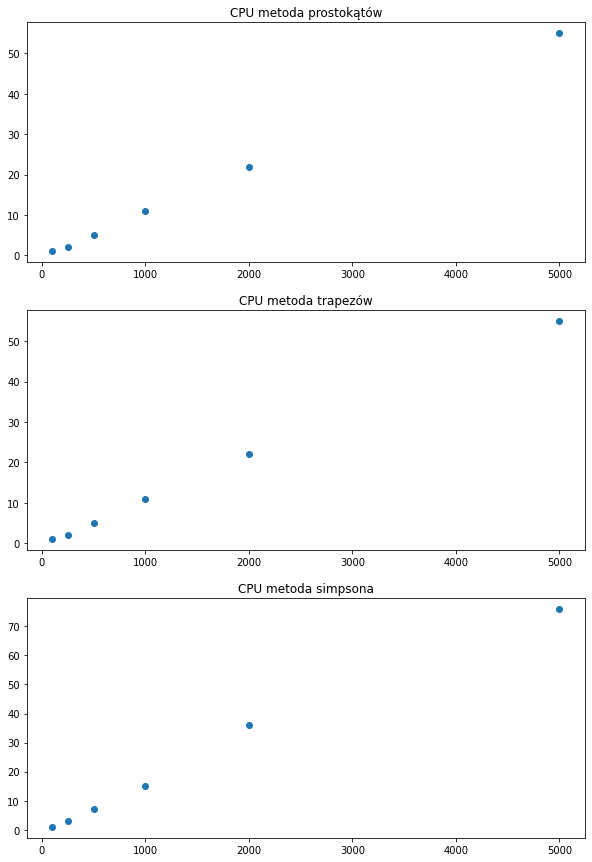

In [39]:
import matplotlib.pyplot as plt
import numpy as np

ilosc_podzialow = (100, 250, 500, 1000, 2000, 5000)
cpu_prostokatow_vector = np.array([1, 2, 5, 11, 22, 55])
cpu_trapezow_vector = np.array([1, 2, 5, 11, 22, 55])
cpu_simpsona_vector = np.array([1, 3, 7, 15, 36, 76])
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].set_title("CPU metoda prostokątów")
axs[0].plot(ilosc_podzialow, cpu_prostokatow_vector, 'o')
axs[1].set_title("CPU metoda trapezów")
axs[1].plot(ilosc_podzialow, cpu_trapezow_vector, 'o', )
axs[2].set_title("CPU metoda simpsona")
axs[2].plot(ilosc_podzialow, cpu_simpsona_vector, 'o', )
plt.show()

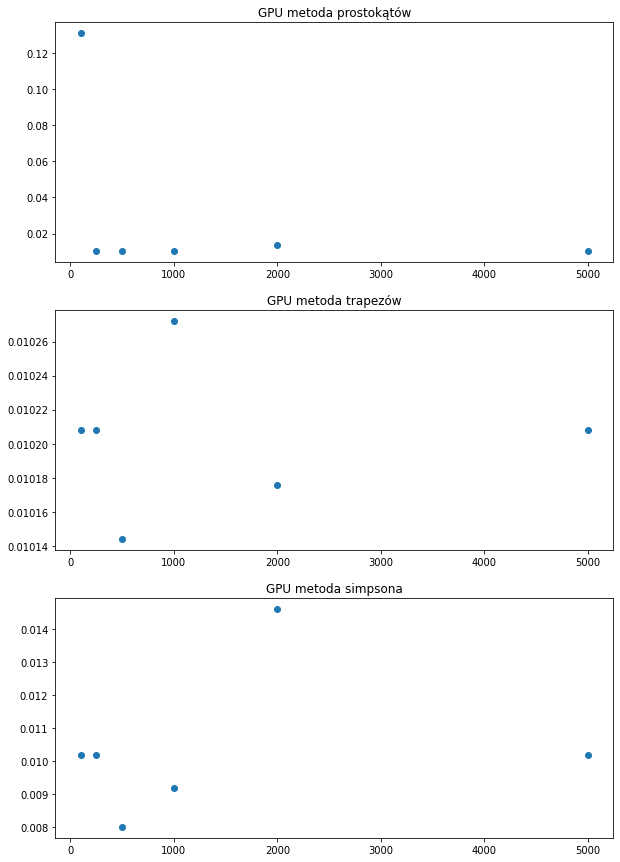

In [40]:
import matplotlib.pyplot as plt
import numpy as np

ilosc_podzialow = (100, 250, 500, 1000, 2000, 5000)
gpu_prostokatow_vector = np.array([0.13088, 0.010208, 0.010208, 0.010208, 0.013472, 0.010176])
gpu_trapezow_vector = np.array([0.010208, 0.010208, 0.010144, 0.010272, 0.010176, 0.010208])
gpu_simpsona_vector = np.array([0.010176, 0.010176, 0.008, 0.009184, 0.014624, 0.010176])
fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].set_title("GPU metoda prostokątów")
axs[0].plot(ilosc_podzialow, gpu_prostokatow_vector, 'o')
axs[1].set_title("GPU metoda trapezów")
axs[1].plot(ilosc_podzialow, gpu_trapezow_vector, 'o', )
axs[2].set_title("GPU metoda simpsona")
axs[2].plot(ilosc_podzialow, gpu_simpsona_vector, 'o', )
plt.show()